# EdTech Payment A/B Testing

In this mini-project, we analyze the impact of a new payment mechanism introduced on an online educational platform that offers courses and learning services to students.

We have the results of an A/B test conducted on an online educational platform. Our aim is to evaluate the effectiveness of a new payment mechanism compared to the existing baseline, investigate statistical significance of observed differences, and provide data-driven recommendations for business implementation.

### Data description:
The dataset contains the following fields:

users.csv - dataset - user devided into control(A) and test(B) groups

logs.csv - dataset - platform login activity during experiment period

payments.csv - dataset - payment transactions of users

# Importing Libraries and Dataset

In [968]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import norm
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(6,4)}, style="white")
sns.set_style("white")

In [704]:
# import datasets
users = pd.read_csv('users.csv')  # users by control / test groups
logs = pd.read_csv('logs.csv', sep=',')  # login activity
payments = pd.read_csv('payments.csv', sep=';')  # payments data

# Exploratory Data Analysis (EDA)

**1. users =>** users devided into control(A) & test (B) groups.

In [708]:
users.head()

,id,group
0,1489,A
1,1627,B
2,1768,B
3,1783,B
4,1794,A


In [710]:
users.id.nunique()

74576

In [712]:
users.isna().sum()

id       0
group    0
dtype: int64

**2. logs =>** users who logged into the platform during the experiment days

In [715]:
logs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [717]:
logs.student_id.nunique()

8341

In [719]:
logs.isna().sum()

student_id    0
dtype: int64

**3. payments =>** payments made by users during the experiment days

In [722]:
payments.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [724]:
payments.student_id.nunique()

541

In [726]:
payments.isna().sum()

student_id    0
rev           0
dtype: int64

### EDA Summary:

There are 74,576 unique users in the df users.

In addition, we have information about 8,341 unique users who logged into the platform during the experiment days, and 541 unique users who made payments during the experiment days.

There are no duplicates and missing values in all these datasets.

To proceed with the analysis, we will merge all datasets into a single one and verify the correctness and completeness of the data.

# Data Preprocessing

**1.** Update df users

In [731]:
# rename column 'id' to 'student_id'
users = users.rename(columns={'id': 'student_id'})

In [733]:
# replace A/B with control/test
users['group'] = users['group'].replace({'A': 'control', 'B': 'test'})

**2.** Update df logs

In [736]:
# for users in the df logs adding 'status' = 'active'
logs['status'] = 'active'

**3.** Update df payments

In [739]:
# for users in the df logs adding 'payment' = 'yes' & rename columns
payments['payment'] = 'yes'
payments = payments.rename(columns={'rev': 'revenue'})

**4.** Merging all datasets & filling missing values

In [742]:
full_df = users.merge(logs, on='student_id', how='left').merge(payments, on='student_id', how='left')

In [744]:
# filling missing values & rename columns
full_df = full_df.fillna({'status': 'inactive', 'revenue': 0, 'payment': 'no'})

In [746]:
# comparing the number of unique users with status 'active' in the new df with the number of unique users in the logs df
full_df.query("status == 'active'").student_id.nunique() == logs.student_id.nunique()

True

In [748]:
# comparing the number of unique users with status 'active' in the new df with the number of unique users in the logs df
full_df.query("payment == 'yes'").student_id.nunique() == payments.student_id.nunique()

True

In [750]:
full_df.head()

,student_id,group,status,revenue,payment
0,1489,control,inactive,0.0,no
1,1627,test,active,990.0,yes
2,1768,test,inactive,0.0,no
3,1783,test,inactive,0.0,no
4,1794,control,inactive,0.0,no


# Analysis

## Q1.
Analyze the combined dataset to identify patterns in user activity, payments, and overall behavior during the experiment.

In [754]:
# create pivot for number of students by status and payments
full_df_pivot = full_df.pivot_table(index='status', columns='payment', values='student_id', aggfunc='count')
full_df_pivot

payment,no,yes
status,,
active,7949,392
inactive,66086,149


In [758]:
# percent of inactive users that made payments
round(full_df.query("status == 'inactive' & payment == 'yes'").revenue.sum() / df.revenue.sum() * 100, 1)

18.4

In [760]:
# analyse full df by groups
full_df_by_groups = full_df.groupby('group', as_index=False).agg({'student_id': 'nunique'})
full_df_by_groups['pct'] = round(full_df_by_groups.student_id / full_df_by_groups.student_id.sum() * 100, 1)

In [762]:
full_df_by_groups.head()

,group,student_id,pct
0,control,37285,50.0
1,test,37291,50.0


## Q1 Summary:
The total number of users is **74,576**, including:

**66,086 =>** inactive users who did not log into the platform and did not make any payments ***=> for testing purposes, these users will be excluded from the final sample***.

**149 =>** inactive users who did not log into the platform, but already made payments. There may be various reasons for this. First, these could be payments for previous periods or installment payments. Second, users might have had auto-payments or subscription payments enabled. Finally, users could have made payments through another resource without visiting the platform (e.g., a mobile app). The share of revenue from these users accounts for 18% of the total revenue. Regardless of the reasons, these users have already made payments and were not sensitive to changes in the payment mechanism ***=> for testing purposes, these users will be excluded from the final sample***.

**8,341 =>** active users including 392 payed users and 7,949 users without payments ***=> these users will be included in the final sample***.

Users were split into control and test groups for testing purposes, with an equal **50/50 distribution**.

## Q2.
Data Preparation for Testing. Analyze the split between control and test groups to ensure that users are evenly distributed.

In [766]:
# final sample for testing => keep only active users
sample = df.query("status == 'active'")

In [768]:
sample.head()

,student_id,group,status,revenue,payment
1,1627,test,active,990.0,yes
10,2085,control,active,0.0,no
12,2215,test,active,0.0,no
43,3391,test,active,0.0,no
45,3401,test,active,0.0,no


In [770]:
# check of completeness
sample.student_id.nunique()

8341

In [772]:
sample.head()

,student_id,group,status,revenue,payment
1,1627,test,active,990.0,yes
10,2085,control,active,0.0,no
12,2215,test,active,0.0,no
43,3391,test,active,0.0,no
45,3401,test,active,0.0,no


In [774]:
# sample by groups
sample_by_groups = final_sample.groupby('group', as_index=False).agg({'student_id': 'nunique'})
sample_by_groups['pct'] = round(sample_by_groups.student_id / sample_by_groups.student_id.sum() * 100, 1)

In [776]:
sample_by_groups

,group,student_id,pct
0,control,4224,50.6
1,test,4117,49.4


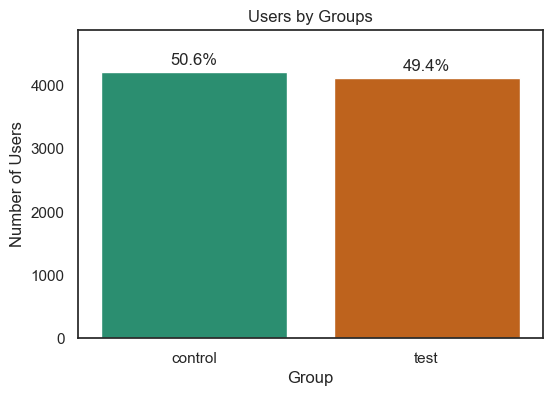

In [778]:
ax = sns.barplot(x='group', y='student_id', data=sample_by_groups, hue='group',
                 order=['control','test'], palette='Dark2')
for container, label in zip(ax.containers, sample_by_groups['pct']):
    ax.bar_label(container, labels=[f"{label:.1f}%"], padding=3)
plt.title('Users by Groups')
plt.xlabel('Group')
plt.ylabel('Number of Users')
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax * 1.1)
plt.show()

## Q2 Summary:
A testing DataFrame was prepared with 8,341 active users.

The distribution between control and test groups was checked and found to be 50.6% vs 49.4%, matching the intended 50/50 split of the full dataset.

## Q3. Hypothesis
**H0:** There is no difference between the new payment mechanism (test group) and the old one (control group).

**H1:** The new payment mechanism (test group) differs significantly from the old one (control group).

## Q4. Metrics
The effectiveness of the new payment mechanism will be analyzed using the following metrics:

**CR (Conversion Rate):** the ratio of paying users to the total number of active users.

**ARPU (Average Revenue per User):** the average revenue per acquired user.

**ARPPU (Average Revenue per Paying User):** the average revenue per paying user.

In [787]:
# calculate metrics by groups
sample_metrics = sample.groupby('group', as_index=False).agg(
    total_revenue_USD = ('revenue', 'sum'),
    CR = ('payment', lambda x: ((x=='yes').sum() / len(x)) * 100),
    ARPU_USD = ('revenue', 'mean'),
    ARPPU_USD = ('revenue', lambda x: x[x>0].mean()))

In [793]:
sample_metrics = sample_metrics.round({'total_revenue_USD': 2, 'CR': 2, 'ARPU_USD': 2, 'ARPPU_USD': 2})

In [795]:
sample_metrics

,group,total_revenue_USD,CR,ARPU_USD,ARPPU_USD
0,control,240938.0,4.52,57.04,1261.46
1,test,226856.0,4.88,55.10,1128.64


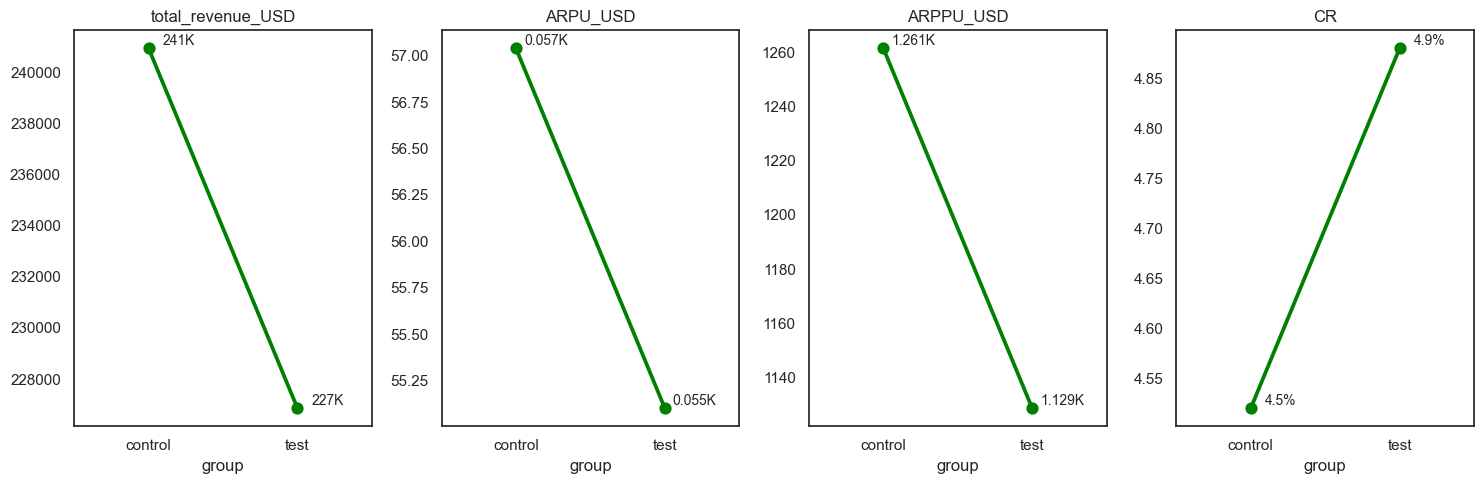

In [801]:
# visualization
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
metrics = ['total_revenue_USD', 'ARPU_USD', 'ARPPU_USD', 'CR']
for ax, metric in zip(axes, metrics):
    sns.pointplot(x='group', y=metric, data=sample_metrics, ax=ax, color='green')
    ax.set_title(metric)
    ax.set_ylabel('')
    for i, row in sample_metrics.iterrows():
        ax.text(
            x=i%2 + 0.2,
            y=row[metric],
            s=(f"{row[metric]/1000:.3f}K" if metric == 'ARPU_USD'
            else f"{row[metric]:.1f}%" if metric == 'CR'
            else f"{row[metric]/1000:.3f}K" if metric == 'ARPPU_USD'
            else f"{row[metric]/1000:.0f}K"),
            ha='center',
            va='bottom',
            fontsize=10
        )
plt.tight_layout()
plt.show()

## Q4 Summary:

**Total Revenue:** In the control group, total revenue was 241K, while in the test group it was 227K. Overall, the total revenue in the test group is slightly lower than in the control group. The difference is small, but the control group generated more revenue.

**ARPU**: The control group had an ARPU of USD 0.057K (USD 57), and the test group had USD 0.055K (USD 55). The average revenue per user is slightly higher in the control group, with a minimal difference of about 2 units.

**ARPPU**: In the control group, ARPPU was USD 1.261K (USD 1,261), compared to USD 1.129K (USD 1,129) in the test group. The average revenue per paying user is higher in the control group, with the test group lagging slightly.

**CR**: The control group had a conversion rate of 4.5%, while the test group achieved 4.9%. Conversion is higher in the test group, indicating that the new payment mechanic led to a small increase in conversion.

Overall, the new payment mechanic in the test group slightly increased the conversion rate, suggesting a higher proportion of paying users. However, the average revenue per user and per paying user decreased, and the total revenue is slightly lower than in the control group.

To make final conclusions, a statistical test is needed to determine whether these differences are significant or just random fluctuations.

## Q5. Statistical Testing of CR
**H0:** The CR in the control and test groups does not differ.

**H1:** The difference in CR between the control and test groups is statistically significant.

Since CR is based on a categorical variable (payment = yes/no), the appropriate method to test the hypothesis is the **Chi-square test** of independence.

In [821]:
# Create a contingency tabl
chi_2 = pd.crosstab(sample['payment'], sample['group'])
chi_2

group,control,test
payment,,
no,4033,3916
yes,191,201


In [825]:
chi2, p, dof, expected = chi2_contingency(chi_2.values)

print("Chi2:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

Chi2: 0.5268937140184259
p-value: 0.4679157422325776
Degrees of freedom: 1
Expected frequencies:
 [[4025.48567318 3923.51432682]
 [ 198.51432682  193.48567318]]


## Q5 Summary:
Since the p-value (0.468) is greater than 0.05, we fail to reject the null hypothesis. 

This indicates that the difference in CR between the control and test groups is not statistically significant. 

In other words, **the new payment system did not lead to a significant change in CR**.

## Q6. Statistical testing of ARPU
**H0:** The average ARPU is the same in the control and test groups.

**H1:** The average ARPU differs between the control and test groups.

To choose the appropriate statistical test for ARPU, we examine the **revenue distribution for all users**.

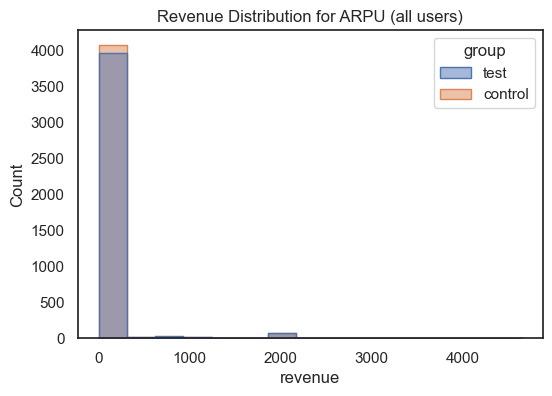

In [889]:
sns.histplot(data=sample, x='revenue', hue='group', alpha=0.5, element='step')
plt.title('Revenue Distribution for ARPU (all users)')
plt.show()

In [983]:
# Determine share of students payed less than USD 500 incuding zero revenue in both groups
round((sample['revenue'] <= 500).mean() * 100, 2)

96.64

In [985]:
# Determine top students by revenue in both groups
sample.revenue.sort_values(ascending=False).head()

38102    4650.0
72633    3660.0
9916     3660.0
36243    3660.0
17483    3660.0
Name: revenue, dtype: float64

* The revenue distribution across all users is highly skewed: most users (around 97%) have zero or very low revenue. A small proportion generates substantially higher amounts (USD 3000+).
* Visual differences between the control and test groups are minimal.
* Because the data does not follow a normal distribution and contains heavy tails, parametric methods such as the t-test are not appropriate. Therefore, we use bootstrap to compare the mean ARPU between groups.

In [970]:
# function for bootstrap
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it=1000,
    statistic=np.mean,
    bootstrap_conf_level=0.95
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

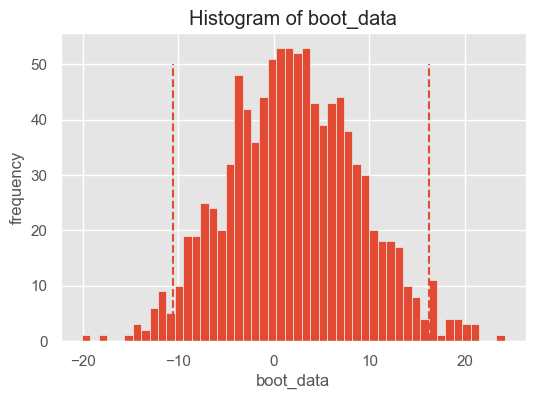

In [1002]:
# bootstrap for ARPU
booted_data_ARPU = get_bootstrap(sample.query("group == 'control'").revenue, 
                                 sample.query("group == 'test'").revenue)

In [1010]:
booted_data_ARPU["p_value"]

0.7597134755942407

In [1012]:
booted_data_ARPU["ci"]

,0
0.025,-10.547236
0.975,16.264412


## Q6 Summary:
The bootstrap analysis of ARPU shows no statistically significant difference between the control and test groups. 

The 95% confidence interval for the mean difference ranges from -10.55 to 16.26, including zero, and the p-value is 0.76. This indicates that the observed difference in ARPU could easily occur by chance.

## Q7. Statistical testing of ARPPU
**H0:** The average ARPPU is the same in the control and test groups.

**H1:** The average ARPPU differs between the control and test groups.

To choose the appropriate statistical test for ARPPU, we examine the **revenue distribution for paying users only**.

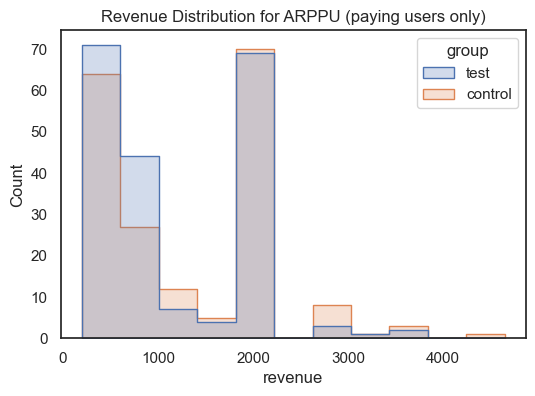

In [887]:
sns.histplot(data=sample[sample['revenue'] > 0], x='revenue', hue='group', element='step')
plt.title('Revenue Distribution for ARPPU (paying users only)')
plt.show()

In [987]:
sample.head()

,student_id,group,status,revenue,payment
1,1627,test,active,990.0,yes
10,2085,control,active,0.0,no
12,2215,test,active,0.0,no
43,3391,test,active,0.0,no
45,3401,test,active,0.0,no


* Most paying users (around 94%) spend relatively little (main peaks up to 2000), with a long right tail reaching 4000+, representing a small group of high spenders.
* The peaks of control and test group distributions are roughly similar. The control group has more users with high spending (2000–4000), while the test group shows a more pronounced peak below 1000, reflecting the contribution of small payments.
* The control group tends to have higher spending, resulting in a higher ARPPU.
* The test group has more low-spending users, which lowers ARPPU. Since the distribution is right-skewed with outliers, bootstrap is used to test for differences in mean ARPPU between groups.
* Because the data does not follow a normal distribution, parametric methods such as the t-test are not appropriate. Therefore, we use bootstrap to compare the mean ARPPU between groups.

  0%|          | 0/1000 [00:00<?, ?it/s]

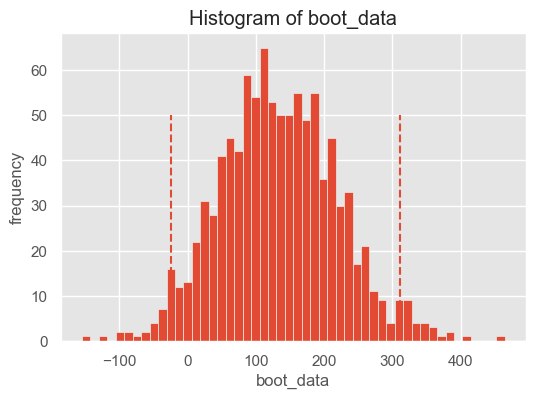

In [1004]:
# bootstrap for ARPU
booted_data_ARPPU = get_bootstrap(sample.query("group == 'control' & payment == 'yes'").revenue, 
                                  sample.query("group == 'test' & payment == 'yes'").revenue)

In [1006]:
booted_data_ARPPU["p_value"]

0.12024429347596313

In [1008]:
booted_data_ARPPU["ci"]

,0
0.025,-24.585438
0.975,310.897524


## Q7 Summary:
The bootstrap analysis of ARPPU shows no statistically significant difference between the control and test groups.

The 95% confidence interval for the mean difference ranges from -24.59 to 310.9, and the p-value is 0.12, indicating that the observed difference could easily occur by chance.

# Overall Project Conclusion:
* The project aimed to evaluate the impact of a new payment mechanism on user behavior and revenue generation. The total user base consisted of 74,576 users. For testing purposes, inactive users were excluded, leaving 8,341 active users (including 392 paying users and 7,949 non-paying users). These active users were randomly split into control and test groups with an approximately 50/50 distribution.
* The effectiveness of the new payment mechanism will be analyzed using the following metrics: CR, ARPU, ARPPU.
* Based on preliminary observations of metrics, we discovered that  CR increased slightly in the test group (4.9% vs 4.5% in the control group) while ARPU and ARPPU were slightly lower in the test group (ARPU: USD 55 vs USD 57; ARPPU: USD 1,129 vs USD 1,261). Total revenue in the test group was marginally lower than in the control group.
* Due to the skewed revenue distribution and presence of outliers, non-parametric methods such as bootstrap analysis were used to compare ARPU and ARPPU. Results showed no statistically significant differences between the control and test groups. Similarly, a Chi-square test for conversion rate yielded a p-value of 0.468, indicating no significant effect of the new payment mechanism.
* Based on the statistical tests conducted (Chi-square for CR and bootstrap for ARPU/ARPPU), H₀ (that there is no difference between the new payment mechanism (test group) and the old one (control group)) cannot be rejected, indicating that the new payment mechanism does not significantly change user payment behavior or revenue.